In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import readLHE
import invariants
import glob

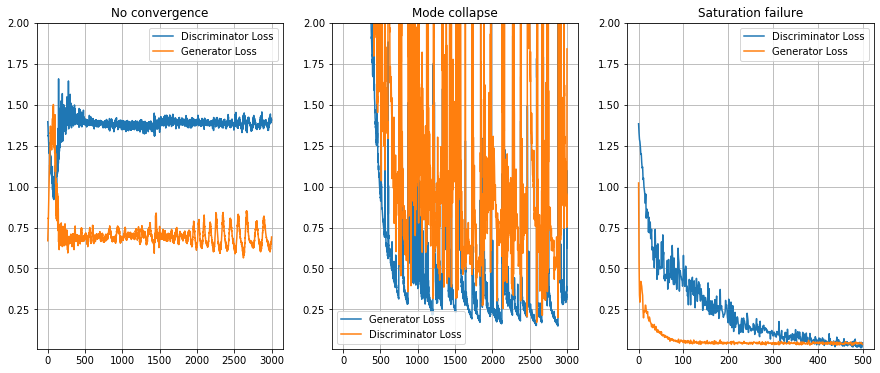

In [2]:
#failures
titles = ['No convergence', 'Mode collapse', 'Saturation failure']
files = glob.glob('../../Tesi/mode_failures/loss*.txt')
labels = ['Discriminator Loss', 'Generator Loss']
losses = [np.loadtxt(files[i]) for i in range(len(files))]
fig, ax = plt.subplots(1,3, figsize=(15,6))
for i in range(len(files)):
    ax[i%3].plot(losses[i][:3000], label=labels[i%2])
    ax[i%3].set_ylim(0.01, 2.0)
    ax[i%3].set_title(titles[i%3])
    ax[i%3].grid(True)
    ax[i%3].legend()

In [4]:
#load models
generator = tf.keras.models.load_model('outputs_adam_1kepochs/generator.h5')
discriminator = tf.keras.models.load_model('outputs_adam_1kepochs/discriminator.h5')

In [5]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200)               0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 2)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 64)        512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10, 10, 64)        0

In [6]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               600       
_________________________________________________________________
batch_normalization_4 (Batch (None, 200)               800       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 10, 2)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 64)        1216      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 10, 10, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 64)       

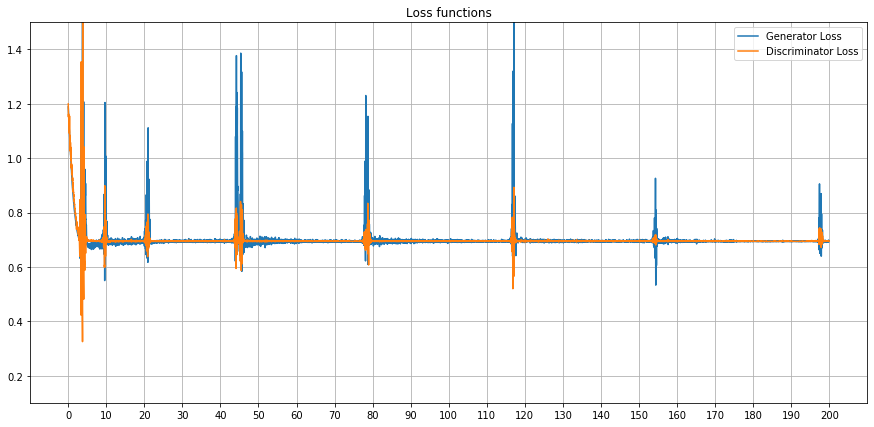

In [7]:
#losses
iter = 100
epochs = 200
d_loss = np.loadtxt('outputs_adam_1kepochs/d_loss.txt')
g_loss = np.loadtxt('outputs_adam_1kepochs/g_loss.txt')

plt.figure(figsize=(15,7))
plt.title('Loss functions')
plt.plot(g_loss, label='Generator Loss')
plt.plot(d_loss, label='Discriminator Loss')
plt.xticks(np.arange(0, len(d_loss)+1, 10*iter), np.arange(0, epochs+1, 10))
plt.ylim(0.1, 1.5)
plt.legend()
plt.grid(True)
plt.show()

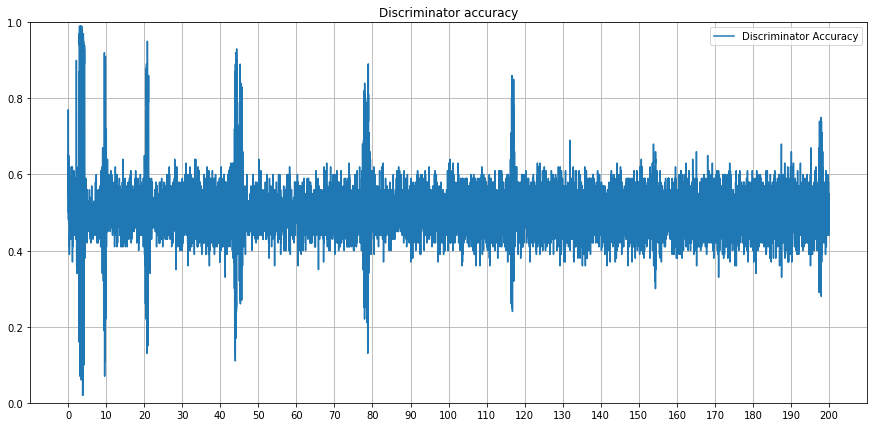

In [8]:
#discriminator accuracy
iter = 100
epochs = 200
d_acc = np.loadtxt('outputs_adam_1kepochs/d_acc.txt')

plt.figure(figsize=(15,7))
plt.title('Discriminator accuracy')
plt.plot(d_acc, label='Discriminator Accuracy')
plt.xticks(np.arange(0, len(d_loss)+1, 10*iter), np.arange(0, epochs+1, 10))
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

In [9]:
file = '../ppttbar_10k_events.lhe'
init, evs = readLHE.readEvent(file)

invar = np.zeros((len(evs),3))
for ev in range(len(evs)):
    invar[ev,0] = invariants.GetEnergySquared(evs[ev])
    invar[ev,1] = invariants.GetMandelT(evs[ev])
    invar[ev,2] = invariants.GetRapidity(init, evs[ev])

pred = np.loadtxt('outputs_adam_1kepochs/pred.txt')

pred[:,0] = (1+pred[:,0])*(max(invar[:,0])-min(invar[:,0]))/2 + min(invar[:,0])
pred[:,1] = (1+pred[:,1])*(max(invar[:,1])-min(invar[:,1]))/2 + min(invar[:,1])
pred[:,2] = (1+pred[:,2])*(max(invar[:,2])-min(invar[:,2]))/2 + min(invar[:,2])

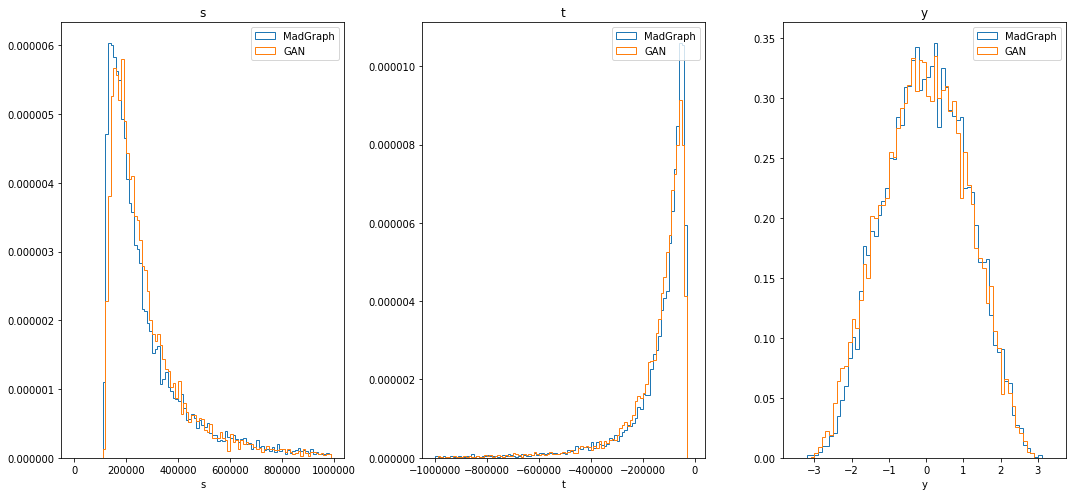

In [10]:
bins = [np.arange(0, 1e6, 1e4), np.arange(-1e6, 0, 1e4), np.arange(-3.5, 3.5, 0.1)]
labels = ['s', 't', 'y']
fig, ax = plt.subplots(1,3, figsize=(15,7))
for i in range(3):
    ax[i].hist(invar[:,i], bins=bins[i], histtype='step', label='MadGraph', density=True)
    ax[i].hist(pred[:,i], bins=bins[i], histtype='step', label='GAN', density=True)
    ax[i].set_title(labels[i])
    ax[i].set_xlabel(labels[i])
    ax[i].legend()
fig.tight_layout()

**SGD - 500k events - 100000 epochs**

In [2]:
import scipy.special
import scipy.stats
import scipy.spatial
from numpy import inf
import pickle
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

def get_kl_js(data_p, data_q):
    pdfp = scipy.stats.rv_histogram(np.histogram(data_p, bins=100))
    pdfq = scipy.stats.rv_histogram(np.histogram(data_q, bins=100))
    p = pdfp.pdf(np.linspace(min(data_p), max(data_p), 100))
    q = pdfq.pdf(np.linspace(min(data_q), max(data_q), 100))
    kl_div = scipy.special.kl_div(p,q)
    kl_div[kl_div == inf] = 0
    js_div = scipy.spatial.distance.jensenshannon(p, q)**2
    return np.sum(kl_div), js_div

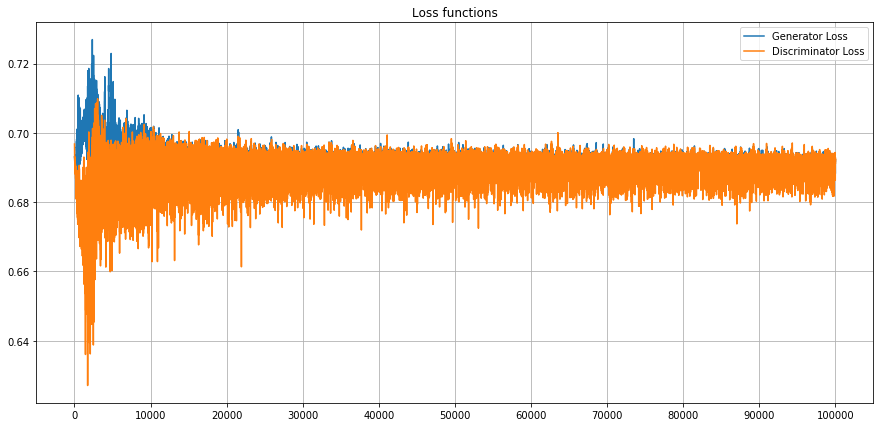

In [7]:
#losses
iter = 1
epochs = 200000
d_loss, _ = np.loadtxt('outputs_sgd_100kepochs/d_loss.txt', unpack=True)
g_loss, _ = np.loadtxt('outputs_sgd_100kepochs/g_loss.txt', unpack=True)

plt.figure(figsize=(15,7))
plt.title('Loss functions')
plt.plot(g_loss, label='Generator Loss')
plt.plot(d_loss, label='Discriminator Loss')
plt.xticks(np.arange(0, len(d_loss)+1, 10000*iter), np.arange(0, epochs+1, 10000))
#plt.ylim(0.1, 1.5)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [35]:
file = '../../Tesi/ttbar_ex/Events/run_02/ppttbar_500k_events.lhe'
evs = readLHE.readEvent(file)
init = readLHE.readInit(file)
invar = np.zeros((readLHE.NEvents(file),3))
i = 0
for ev in evs:
    invar[i,0] = invariants.GetEnergySquared(ev)
    invar[i,1] = invariants.GetMandelT(ev)
    invar[i,2] = invariants.GetRapidity(init, ev)
    i += 1

pred = np.loadtxt('outputs_sgd_100kepochs/pred.txt')

pred[:,0] = pred[:,0]*np.std(invar[:,0])+np.mean(invar[:,0])
pred[:,1] = pred[:,1]*np.std(invar[:,1])+np.mean(invar[:,1])
pred[:,2] = pred[:,2]*np.std(invar[:,2])+np.mean(invar[:,2])

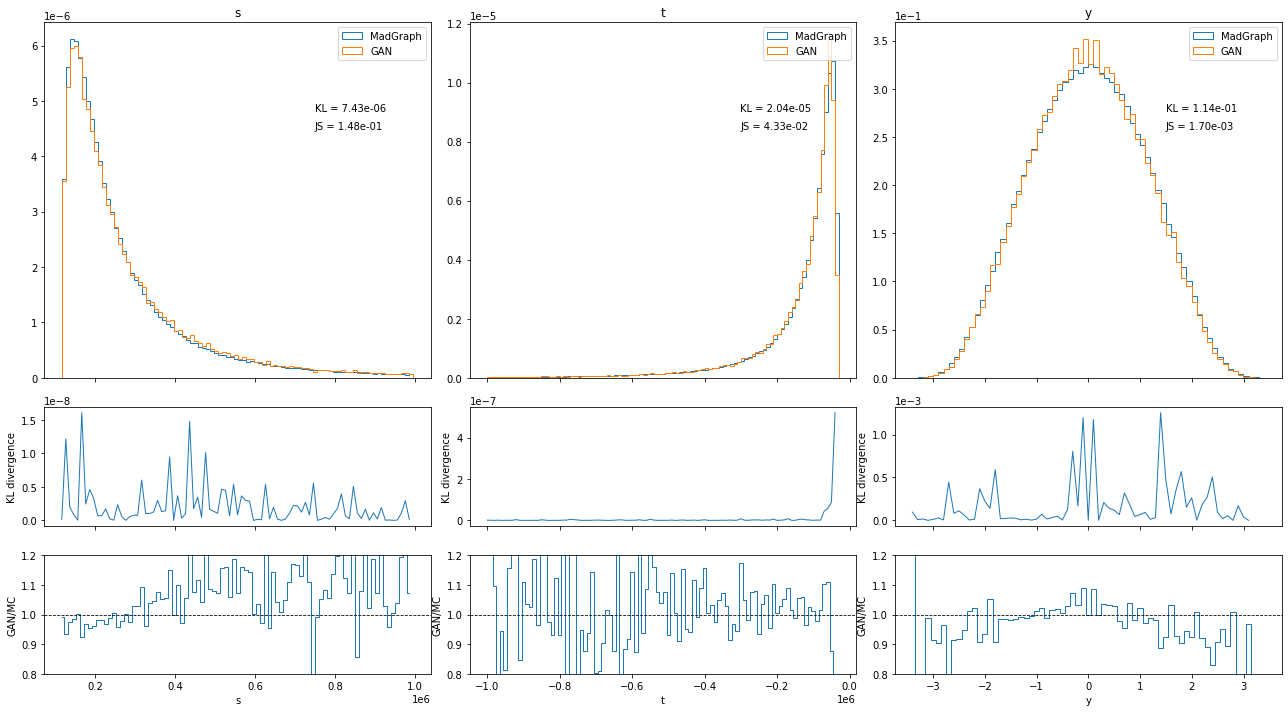

In [36]:
bins = [np.arange(min(invar[:,0]), 1e6, 1e4), np.arange(-1e6, max(invar[:,1]), 1e4), np.arange(min(invar[:,2]), max(invar[:,2]), 0.1)]
labels = ['s', 't', 'y']
fig, ax = plt.subplots(3,3, figsize=(18,10), gridspec_kw={'height_ratios': [3,1,1]}, sharex='col')

for i in range(3):
    valt, bs, _ = ax[0,i].hist(invar[:,i], bins=bins[i], histtype='step', label='MadGraph', density=True)
    valg, bs, _ = ax[0,i].hist(pred[:,i], bins=bins[i], histtype='step', label='GAN', density=True)
    ax[0,i].set_title(labels[i])
    ax[0,i].legend(loc='best')
    ax[0,i].annotate('KL = {:.2e}'.format(np.sum(get_kl_js(invar[:,i], pred[:,i])[0])), xy=(0.70, 0.75), xycoords='axes fraction')
    ax[0,i].annotate('JS = {:.2e}'.format(get_kl_js(invar[:,i], pred[:,i])[1]), xy=(0.70, 0.70), xycoords='axes fraction')
    ax[0,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].plot(bs[:-1], scipy.special.kl_div(valt,valg), linewidth='1')
    ax[1,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].set_ylabel('KL divergence')
    ax[2,i].step(bs[:-1], valg/valt, where='mid', linewidth='1')
    ax[2,i].set_ylim(0.8,1.2)
    
    ax[2,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[2,i].set_xlabel(labels[i])
    ax[2,i].axhline(1, ls ='--', color='black', lw='0.8')
    ax[2,i].set_ylabel('GAN/MC')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15,wspace=0.1)

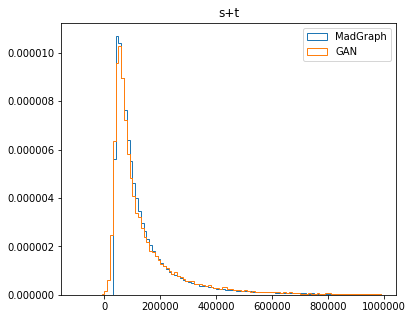

In [37]:
st_dts = np.delete(invar, 2, axis=1)
st_gen = np.delete(pred, 2, axis=1)
plt.figure(figsize=(6,5))
plt.hist(np.sum(st_dts, axis=1),bins=np.arange(-1e5,1e6, 1e4), histtype='step', label='MadGraph', density=True)
plt.hist(np.sum(st_gen, axis=1),bins=np.arange(-1e5,1e6, 1e4), histtype='step', label='GAN', density=True)
plt.title('s+t')
plt.legend()
plt.show()

**Preprocessed input with MinMax and PowerTransformer - 100k epochs**

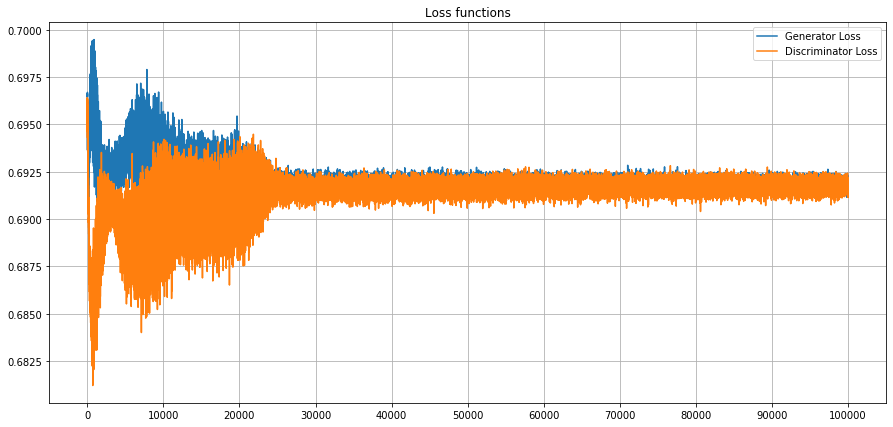

In [32]:
#losses
iter = 1
epochs = 200000
d_loss, _ = np.loadtxt('outputs_gauss_100k/d_loss.txt', unpack=True)
g_loss, _ = np.loadtxt('outputs_gauss_100k/g_loss.txt', unpack=True)

plt.figure(figsize=(15,7))
plt.title('Loss functions')
plt.plot(g_loss, label='Generator Loss')
plt.plot(d_loss, label='Discriminator Loss')
plt.xticks(np.arange(0, len(d_loss)+1, 10000*iter), np.arange(0, epochs+1, 10000))
#plt.ylim(0.1, 1.5)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [7]:
file = '../../Tesi/ttbar_ex/Events/run_02/ppttbar_500k_events.lhe'
evs = readLHE.readEvent(file)
init = readLHE.readInit(file)
invar = np.zeros((readLHE.NEvents(file),3))
i = 0
for ev in evs:
    invar[i,0] = invariants.GetEnergySquared(ev)
    invar[i,1] = invariants.GetMandelT(ev)
    invar[i,2] = invariants.GetRapidity(init, ev)
    i += 1

ene_scaler = PowerTransformer(method='box-cox', standardize=True)
ene_scaler.fit(invar[:,0].reshape(-1,1))
t_scaler = PowerTransformer(standardize=True)
t_scaler.fit(invar[:,1].reshape(-1,1))
minmax_scaler = MinMaxScaler((-1,1))
minmax_scaler.fit(invar)

pred = np.loadtxt('../../Tesi/pred.txt')

pred = minmax_scaler.inverse_transform(pred)
pred[:,0] = ene_scaler.inverse_transform(pred[:,0].reshape(-1,1)).flatten()
pred[:,1] = t_scaler.inverse_transform(pred[:,1].reshape(-1,1)).flatten()

In [14]:
ene_scaler = PowerTransformer(method='box-cox', standardize=True)
ene_scaler.fit(invar[:,0].reshape(-1,1))
t_scaler = PowerTransformer(standardize=True)
t_scaler.fit(invar[:,1].reshape(-1,1))
minmax_scaler = MinMaxScaler((-1,1))
minmax_scaler.fit(invar)
pred = np.loadtxt('../../Tesi/pred.txt')

pred = minmax_scaler.inverse_transform(pred)
#pred[:,0] = ene_scaler.inverse_transform(pred[:,0].reshape(-1,1)).flatten()
#pred[:,1] = t_scaler.inverse_transform(pred[:,1].reshape(-1,1)).flatten()
pred

array([[ 1.01367097e+07, -9.10055361e+06,  9.18853349e-01],
       [ 1.24954737e+07, -1.29324811e+07, -1.01275822e+00],
       [ 4.74891577e+06, -6.06575717e+06,  1.66324115e-01],
       ...,
       [ 7.96655449e+06, -1.97488174e+06, -1.91594943e+00],
       [ 3.61118766e+06, -7.58429686e+06, -4.26948280e-01],
       [ 1.08868508e+07, -5.91196009e+06,  4.05962110e-01]])

In [21]:
t_scaler.inverse_transform(pred[:,1].reshape(-1,1))

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]])

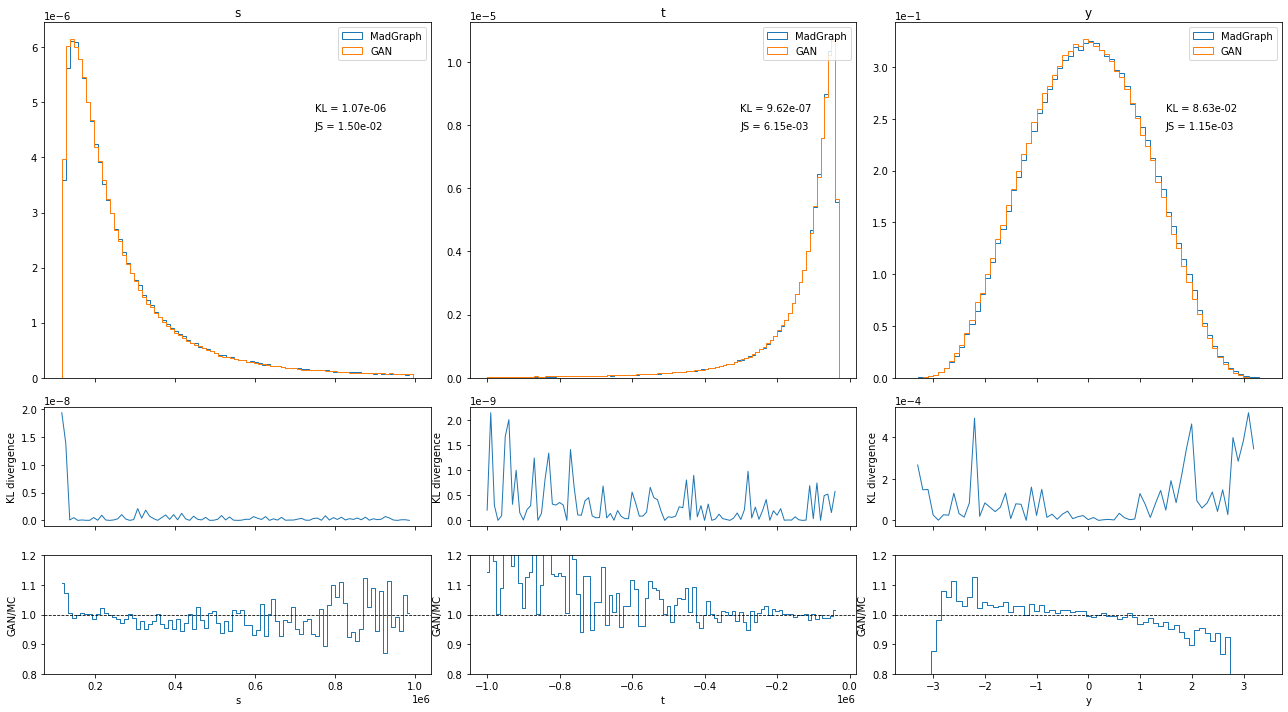

In [28]:
bins = [np.arange(min(invar[:,0]), 1e6, 1e4), np.arange(-1e6, max(invar[:,1]), 1e4), np.arange(min(invar[:,2]), max(invar[:,2]), 0.1)]
labels = ['s', 't', 'y']
fig, ax = plt.subplots(3,3, figsize=(18,10), gridspec_kw={'height_ratios': [3,1,1]}, sharex='col')

for i in range(3):
    valt, bs, _ = ax[0,i].hist(invar[:,i], bins=bins[i], histtype='step', label='MadGraph', density=True)
    valg, bs, _ = ax[0,i].hist(pred[:,i], bins=bins[i], histtype='step', label='GAN', density=True)
    ax[0,i].set_title(labels[i])
    ax[0,i].legend(loc='best')
    ax[0,i].annotate('KL = {:.2e}'.format(np.sum(get_kl_js(invar[:,i], pred[:,i])[0])), xy=(0.70, 0.75), xycoords='axes fraction')
    ax[0,i].annotate('JS = {:.2e}'.format(get_kl_js(invar[:,i], pred[:,i])[1]), xy=(0.70, 0.70), xycoords='axes fraction')
    ax[0,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].plot(bs[:-1], scipy.special.kl_div(valt,valg), linewidth='1')
    ax[1,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].set_ylabel('KL divergence')
    ax[2,i].step(bs[:-1], valg/valt, where='mid', linewidth='1')
    ax[2,i].set_ylim(0.8,1.2)
    
    ax[2,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[2,i].set_xlabel(labels[i])
    ax[2,i].axhline(1, ls ='--', color='black', lw='0.8')
    ax[2,i].set_ylabel('GAN/MC')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15,wspace=0.1)

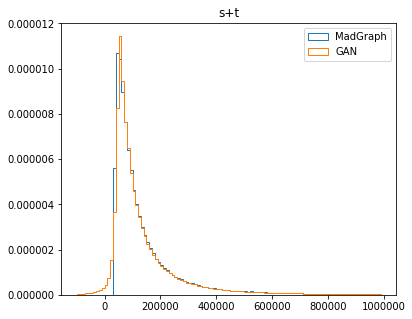

In [31]:
st_dts = np.delete(invar, 2, axis=1)
st_gen = np.delete(pred, 2, axis=1)
plt.figure(figsize=(6,5))
plt.hist(np.sum(st_dts, axis=1),bins=np.arange(-1e5,1e6, 1e4), histtype='step', label='MadGraph', density=True)
plt.hist(np.sum(st_gen, axis=1),bins=np.arange(-1e5,1e6, 1e4), histtype='step', label='GAN', density=True)
plt.title('s+t')
plt.legend()
plt.show()